# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
(validation_images, validation_labels) = (train_images[50000:], train_labels[50000:])
(train_images, train_labels) = (train_images[:50000], train_labels[:50000])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [3]:
train_images_expanded = np.expand_dims(train_images, axis = 3)
validation_images_expanded = np.expand_dims(validation_images, axis = 3)
test_images_expanded = np.expand_dims(test_images, axis = 3)
train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [5]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    history = model_name.fit(
    ti, tl,
    epochs = epochs,
    validation_data = (vi, vl))
    model_name.summary()
    return history
def write_to_json(dictionary, gmean, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [6]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 159us/sample - loss: 0.4010 - acc: 0.8865 - val_loss: 0.1423 - val_acc: 0.9623
Epoch 2/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.1152 - acc: 0.9655 - val_loss: 0.0852 - val_acc: 0.9764
Epoch 3/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0781 - acc: 0.9771 - val_loss: 0.0721 - val_acc: 0.9791
Epoch 4/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0614 - acc: 0.9819 - val_loss: 0.0567 - val_acc: 0.9837
Epoch 5/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0514 - acc: 0.9848 - val_loss: 0.0504 - val_acc: 0.9867
Epoch 6/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0437 - acc: 0.9870 - val_loss: 0.0489 - val_acc: 0.9862
Epoch 7/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0376 - acc: 0.9878 - val_l

In [7]:
baseline_probab = tf.keras.models.Sequential([baseline, tf.keras.layers.Softmax()])
baseline_probab.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                197018    
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 197,018
Trainable params: 197,018
Non-trainable params: 0
_________________________________________________________________


In [8]:
history.history

{'loss': [0.40097944573283195,
  0.11518442195028067,
  0.07808244839251041,
  0.06139210997465998,
  0.05138453656576574,
  0.04374182277299464,
  0.03762027331748046,
  0.033285588168539104,
  0.029552520315945147,
  0.026399197155861184,
  0.023993404624229296,
  0.021008145888969303,
  0.018168611429417506,
  0.017218346106589306,
  0.015261391953423154,
  0.013176212509323377,
  0.012167829024911625,
  0.010322019937847217,
  0.009434466619607992,
  0.00867256511011161],
 'acc': [0.8865,
  0.96548,
  0.9771,
  0.98186,
  0.98476,
  0.98698,
  0.98784,
  0.98974,
  0.99082,
  0.99194,
  0.99278,
  0.99304,
  0.99438,
  0.9946,
  0.99538,
  0.99582,
  0.9961,
  0.99666,
  0.99742,
  0.9975],
 'val_loss': [0.14228270832747222,
  0.08515502809137106,
  0.07212631533928215,
  0.056664934997446834,
  0.05043486579824239,
  0.04890282095298171,
  0.045743393174349334,
  0.04769130050130189,
  0.041961871520010754,
  0.04031426881700754,
  0.03811304400530062,
  0.040375582126533846,
  0.

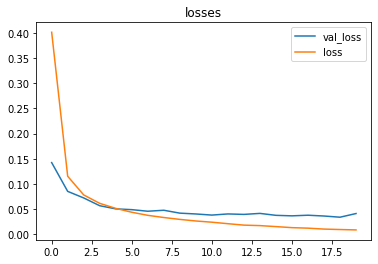

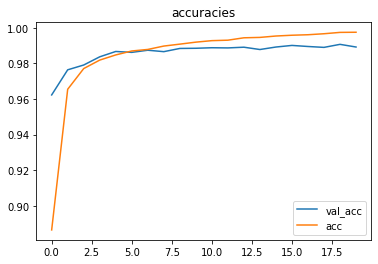

In [9]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [10]:
baseline_test_preds = tf.argmax(baseline_probab(test_images_tf), axis=-1)
baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                       correction = np.finfo(np.float32).eps)
print(baseline_gmean)

0.9905713093078085


In [11]:
#write_to_json(history.history, baseline_gmean, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.4 \rho=10$

{0: 4506, 1: 4506, 2: 451, 3: 4506, 4: 451, 5: 4506, 6: 4506, 7: 451, 8: 4506, 9: 451}


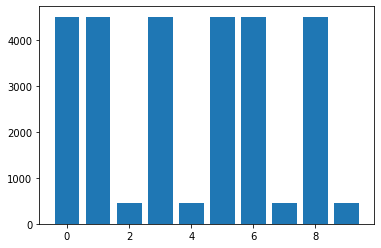

mu = 0.4, rho = 9.991130820399112


In [12]:
(imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, train_labels, 0.4, 10)
print(hf.Imbalance.get_set_distribution(imb_train_labels))
hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0

### check model behavior on imbalanced set

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [22]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, imb_train_images_tf, imb_train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 28840 samples, validate on 10000 samples
Epoch 1/20
28840/28840 [==============================] - 4s 155us/sample - loss: 0.5610 - acc: 0.8319 - val_loss: 0.3859 - val_acc: 0.8827
Epoch 2/20
28840/28840 [==============================] - 4s 135us/sample - loss: 0.1422 - acc: 0.9566 - val_loss: 0.2391 - val_acc: 0.9278
Epoch 3/20
28840/28840 [==============================] - 4s 135us/sample - loss: 0.0958 - acc: 0.9702 - val_loss: 0.1989 - val_acc: 0.9414
Epoch 4/20
28840/28840 [==============================] - 4s 135us/sample - loss: 0.0751 - acc: 0.9763 - val_loss: 0.1569 - val_acc: 0.9546
Epoch 5/20
28840/28840 [==============================] - 4s 135us/sample - loss: 0.0634 - acc: 0.9801 - val_loss: 0.1423 - val_acc: 0.9571
Epoch 6/20
28840/28840 [==============================] - 4s 135us/sample - loss: 0.0542 - acc: 0.9836 - val_loss: 0.1263 - val_acc: 0.9603
Epoch 7/20
28840/28840 [==============================] - 4s 134us/sample - loss: 0.0473 - acc: 0.9858 - val_l

In [15]:
baseline_probab = tf.keras.models.Sequential([baseline, tf.keras.layers.Softmax()])
baseline_probab.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 10)                197018    
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 197,018
Trainable params: 197,018
Non-trainable params: 0
_________________________________________________________________


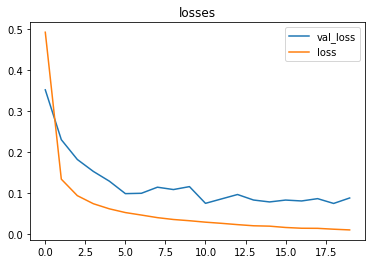

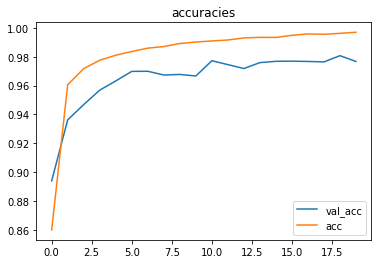

In [16]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [17]:
baseline_test_preds = tf.argmax(baseline_probab(test_images_tf), axis=-1)
baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                       correction = np.finfo(np.float32).eps)
print(baseline_gmean)

0.9757385194937309
